# Gesture Recognition
**Problem Statement:** This problem revolves around integrating gesture recognition into a smart TV, enhancing user interaction by eliminating the need for a remote. The goal is to build a 3D Conv model that will enable the TV to interpret five specific hand gestures captured by a webcam in real time and execute the corresponding commands. Below are the 5 gestures and commands:
-  Thumbs up: Increase the volume.
-  Thumbs down: Decrease the volume.
-  Left swipe: Jump backwards 10 seconds.
-  Right swipe: Jump forward 10 seconds.
-  Stop: Pause the current playback.

# 1. Data Loading

In [1]:
# Import Necessary Libraries
import os
import cv2
import numpy as np
import random as rn
import datetime
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import (
    Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, 
    Conv3D, MaxPooling3D, Dropout, Input, Conv2D, MaxPooling2D, LSTM
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.backend import clear_session
clear_session()

We set the random seed so that the results don't vary drastically.

In [2]:
# Setting seeds for reproducibility
seed_value=30
np.random.seed(seed_value)
rn.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 16

# 2. Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [5]:
def generator(source_path, folder_list, batch_size):
    print('Source path =', source_path, '; batch size =', batch_size)
    # Create a list of image numbers
    img_idx = list(range(0, 30))
    
    while True:
        # Shuffle the folder list to ensure randomness for each epoch
        t = np.random.permutation(folder_list)
        
        # Calculate the number of batches
        num_batches = len(t) // batch_size
        
        # Iterate over the number of batches
        for batch in range(num_batches): 
            # Prepare batch_data and batch_labels arrays
            batch_data = np.zeros((batch_size, len(img_idx), 120, 120, 3))  # Shape: (batch_size, num_frames, height, width, channels)
            batch_labels = np.zeros((batch_size, 5))  # Shape: (batch_size, num_classes)

            # Iterate over the batch_size (for each folder in the batch)
            for folder in range(batch_size):
                folder_path = os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)
                
                # Iterate over the selected frames (img_idx)
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(os.path.join(folder_path, imgs[item]), cv2.IMREAD_UNCHANGED).astype(np.float32)

                    # Crop and resize the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:, 20:140, :], (120, 120), interpolation=cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image, (120, 120), interpolation=cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalize and assign each channel (R, G, B)
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255
                
                # One-hot encode the labels (assuming label is the 3rd element of the string after splitting by ';')
                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            # Yield the batch data and labels
            yield batch_data, batch_labels 
        
        # Handling the remaining data points that don't fill a complete batch
        if len(t) % batch_size != 0:
            remaining_batch_data = np.zeros((len(t) % batch_size, 30, 120, 120, 3))  # Ensure 30 frames
            remaining_batch_labels = np.zeros((len(t) % batch_size, 5))

            for folder in range(len(t) % batch_size):
                folder_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)
                
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(os.path.join(folder_path, imgs[item]), cv2.IMREAD_UNCHANGED).astype(np.float32)

                    # Crop and resize the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:, 20:140, :], (120, 120), interpolation=cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image, (120, 120), interpolation=cv2.INTER_AREA).astype(np.float32)

                    # Normalize and assign each channel (R, G, B)
                    remaining_batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    remaining_batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    remaining_batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                # One-hot encode the labels
                label = int(t[folder + (num_batches * batch_size)].strip().split(';')[2])
                remaining_batch_labels[folder, label] = 1

            # Yield the remaining batch data and labels
            yield remaining_batch_data, remaining_batch_labels

# 3. Model Building

## Model 1
-  Model - The model consists of 2 Conv3D layers with Batch Normalization and MaxPooling3D, followed by a Flatten layer and 2 Dense layers. 
-  Number of Images - 30
-  Image Size - 120X120
-  Number of epoch - 30
-  Batch Size - 16

In [6]:
# Define the model
model = models.Sequential()

# First Conv3D layer
model.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=(30, 120, 120, 3))) 
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D layer
model.add(Conv3D(16, (3, 3, 3), activation='relu'))  
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(64, activation='relu'))  
model.add(Dropout(0.3))  

# Output layer
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Create a directory to store the model checkpoints
model_name = 'first_conv3d_models/' 
if not os.path.exists(model_name):
    os.mkdir(model_name)

# File path for saving the model checkpoints with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Model checkpoint callback with save_freq instead of period
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True,  
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch') 


# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate is reduced
    patience=5,          # Number of epochs with no improvement before reducing the learning rate
    verbose=1,           # 1: Print a message when learning rate is reduced
    min_lr=1e-6          # Minimum learning rate
)

# Define Early stopping for stopping the training if accuracy does not increase
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5
)
# Add both callbacks to the list
callbacks_list = [early_stopping, checkpoint, LR]

# Calculate steps_per_epoch and validation_steps
if num_train_sequences % batch_size == 0:
    steps_per_epoch = num_train_sequences // batch_size
else:
    steps_per_epoch = num_train_sequences // batch_size + 1

if num_val_sequences % batch_size == 0:
    validation_steps = num_val_sequences // batch_size
else:
    validation_steps = num_val_sequences // batch_size + 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 118, 118, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 28, 118, 118, 8)  32        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 59, 59, 8)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 57, 57, 16)    3472      
                                                                 
 batch_normalization_1 (Batc  (None, 12, 57, 57, 16)   64        
 hNormalization)                                                 
                                                        

2024-12-04 09:14:15.970782: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-12-04 09:14:15.970842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


In [7]:
# Start model training
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,initial_epoch=0)

Source path = datasets/Project_data/train ; batch size = 16
Epoch 1/30


2024-12-04 09:14:18.611011: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 12.2067 - categorical_accuracy: 0.3394Source path = datasets/Project_data/val ; batch size = 16

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to first_conv3d_models/model-00001-12.20673-0.33937-3.56812-0.23000.keras
42/42 [==============================] - 50s 1s/step - loss: 12.2067 - categorical_accuracy: 0.3394 - val_loss: 3.5681 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.9175 - categorical_accuracy: 0.3047
Epoch 00002: val_categorical_accuracy improved from 0.23000 to 0.33000, saving model to first_conv3d_models/model-00002-1.91752-0.30468-2.97477-0.33000.keras
42/42 [==============================] - 48s 1s/step - loss: 1.9175 - categorical_accuracy: 0.3047 - val_loss: 2.9748 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.5524 - categorical_accu

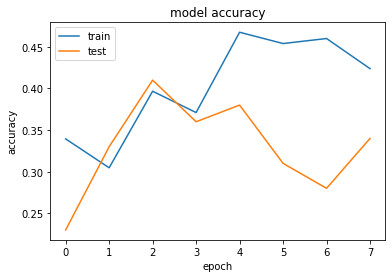

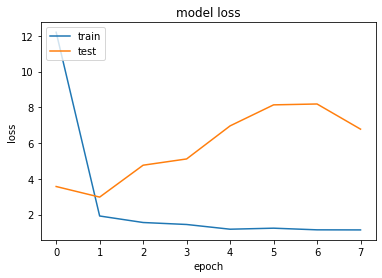

In [8]:
# Plotting the result of Model:

# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Result:**
-  loss: 1.5524
-  categorical_accuracy: 0.3967
-  val_loss: 4.7615
-  val_categorical_accuracy: 0.4100
-  Result: Poor generalization; low accuracy on both training and validation sets.
-  Next Step: Increase model capacity by adding a layer

## Model 2
-  Model - The model consists of 3 Conv3D layers with Batch Normalization and MaxPooling3D, followed by a Flatten layer and 2 Dense layers. 
-  Number of Images - 30
-  Image Size - 120X120
-  Number of epoch - 30
-  Batch Size - 16

In [9]:
# Define the model
model = models.Sequential()

# First Conv3D layer
model.add(Conv3D(8, (3, 3, 3), activation='relu', input_shape=(30, 120, 120, 3))) 
model.add(BatchNormalization()) 
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D layer
model.add(Conv3D(16, (3, 3, 3), activation='relu'))
model.add(BatchNormalization()) 
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D layer
model.add(Conv3D(32, (3, 3, 3), activation='relu'))
model.add(BatchNormalization()) 
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.3))

# Flatten the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(5, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Create a directory to store the model checkpoints
model_name =  'second_conv3d_models/' 
if not os.path.exists(model_name):
    os.mkdir(model_name)

# File path for saving the model checkpoints with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Model checkpoint callback with save_freq instead of period
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True,  
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch') 

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate is reduced
    patience=5,          # Number of epochs with no improvement before reducing the learning rate
    verbose=1,           # 1: Print a message when learning rate is reduced
    min_lr=1e-6          # Minimum learning rate
)

# Define Early stopping for stopping the training if accuracy does not increase
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5
)
# Add both callbacks to the list
callbacks_list = [early_stopping, checkpoint, LR]

# Calculate steps_per_epoch and validation_steps
if num_train_sequences % batch_size == 0:
    steps_per_epoch = num_train_sequences // batch_size
else:
    steps_per_epoch = num_train_sequences // batch_size + 1

if num_val_sequences % batch_size == 0:
    validation_steps = num_val_sequences // batch_size
else:
    validation_steps = num_val_sequences // batch_size + 1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 28, 118, 118, 8)   656       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 14, 59, 59, 8)    0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 12, 57, 57, 16)    3472      
                                                                 
 batch_normalization_3 (Batc  (None, 12, 57, 57, 16)   64        
 hNormalization)                                                 
                                                      

In [10]:
# Start model training
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Source path = datasets/Project_data/train ; batch size = 16
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 3.4466 - categorical_accuracy: 0.4314Source path = datasets/Project_data/val ; batch size = 16

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18000, saving model to second_conv3d_models/model-00001-3.44663-0.43137-3.56668-0.18000.keras
42/42 [==============================] - 50s 1s/step - loss: 3.4466 - categorical_accuracy: 0.4314 - val_loss: 3.5667 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.1779 - categorical_accuracy: 0.5535
Epoch 00002: val_categorical_accuracy improved from 0.18000 to 0.25000, saving model to second_conv3d_models/model-00002-1.17788-0.55354-6.70850-0.25000.keras
42/42 [==============================] - 48s 1s/step - loss: 1.1779 - categorical_accuracy: 0.5535 - val_loss: 6.7085 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
42/42 [=====

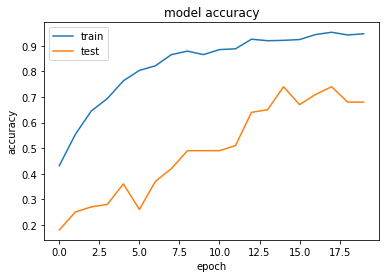

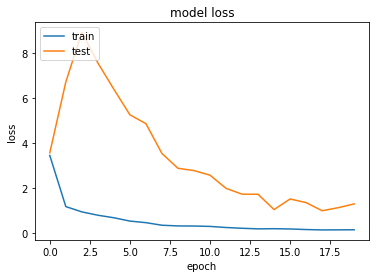

In [11]:
# Plotting the result of Model:

# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Result:**
-  loss: 0.1958
-  categorical_accuracy: 0.9216
-  val_loss: 1.0449
-  val_categorical_accuracy: 0.7400 
-  Result: Overfitting; high training accuracy but lower validation accuracy.
-  Next Step: Increasing dropout and adding an additional layer

## Model 3
-  Model - The model consists of 4 Conv3D layers with Batch Normalization and MaxPooling3D, followed by a Flatten layer, 2 Dense layers and Dropout. Increasing the dropout rates in various layers.
-  Number of Images - 30
-  Image Size - 120X120
-  Number of epoch - 30
-  Batch Size - 16

In [13]:
model = models.Sequential()

# First Conv3D layer
model.add(Conv3D(8, (3, 3, 3), activation='relu', padding='same', input_shape=(30, 120, 120, 3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv3D layer
model.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D layer
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 1))) 

# Fourth Conv3D layer with 64 filters
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 1)))  
model.add(Dropout(0.3))

# Flatten the output
model.add(Flatten())
model.add(Dropout(0.4))

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# Output layer
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Create a directory to store the model checkpoints
model_name =  'third_conv3d_models/' 
if not os.path.exists(model_name):
    os.mkdir(model_name)

# File path for saving the model checkpoints with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Model checkpoint callback with save_freq instead of period
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True,  
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch') 

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate is reduced
    patience=5,          # Number of epochs with no improvement before reducing the learning rate
    verbose=1,           # 1: Print a message when learning rate is reduced
    min_lr=1e-6          # Minimum learning rate
)

# Define Early stopping for stopping the training if accuracy does not increase
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5
)
# Add both callbacks to the list
callbacks_list = [early_stopping, checkpoint, LR]

# Calculate steps_per_epoch and validation_steps
if num_train_sequences % batch_size == 0:
    steps_per_epoch = num_train_sequences // batch_size
else:
    steps_per_epoch = num_train_sequences // batch_size + 1

if num_val_sequences % batch_size == 0:
    validation_steps = num_val_sequences // batch_size
else:
    validation_steps = num_val_sequences // batch_size + 1

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 15, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_6 (Batc  (None, 15, 60, 60, 16)   64        
 hNormalization)                                                 
                                                      

In [14]:
# Start model training
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Source path = datasets/Project_data/train ; batch size = 16
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 2.7303 - categorical_accuracy: 0.3922Source path = datasets/Project_data/val ; batch size = 16

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21000, saving model to third_conv3d_models/model-00001-2.73033-0.39216-1.99490-0.21000.keras
42/42 [==============================] - 53s 1s/step - loss: 2.7303 - categorical_accuracy: 0.3922 - val_loss: 1.9949 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.1558 - categorical_accuracy: 0.5445
Epoch 00002: val_categorical_accuracy improved from 0.21000 to 0.26000, saving model to third_conv3d_models/model-00002-1.15578-0.54449-3.50078-0.26000.keras
42/42 [==============================] - 52s 1s/step - loss: 1.1558 - categorical_accuracy: 0.5445 - val_loss: 3.5008 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/30
42/42 [=======

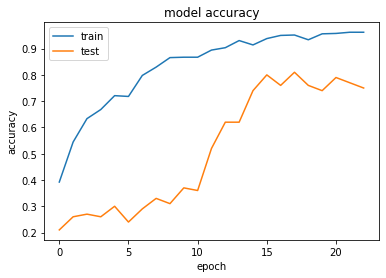

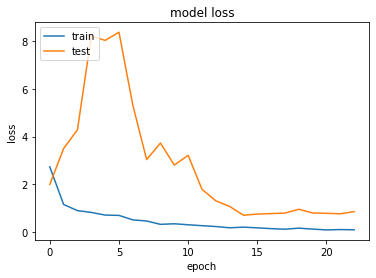

In [15]:
# Plotting the result of Model:

# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Result:**
-  loss: 0.1206
-  categorical_accuracy: 0.9517
-  val_loss:  0.7971
-  val_categorical_accuracy: 0.8100
-  Result: Balanced performance with good generalization; validation accuracy of 81%.
-  Next Step: Trying with CNN LSTM Model

## Model 4
-  Model - The model consists 2 Conv2D Layers with TimeDistributed wrapper, BatchNormalization, MaxPooling2D and Flatten Layer after TimeDistributed for flattening each frame's feature maps, LSTM Layer with 128 units for sequence processing and a dropout layer is also present after the dense layer.
-  Number of Images - 30
-  Image Size - 120X120
-  Number of epoch - 30
-  Batch Size - 16

In [16]:
# Define the model
model = models.Sequential()

# First Conv2D layer
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=(30, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Second Conv2D layer
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Flatten the output
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(128, return_sequences=False, dropout=0.5))

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4)) 

# Output layer
model.add(Dense(5, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Create a directory to store the model checkpoints
model_name = 'first_cnnlstm_models/' 
if not os.path.exists(model_name):
    os.mkdir(model_name)

# File path for saving the model checkpoints with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Model checkpoint callback with save_freq instead of period
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True,  
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch') 

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate is reduced
    patience=5,          # Number of epochs with no improvement before reducing the learning rate
    verbose=1,           # 1: Print a message when learning rate is reduced
    min_lr=1e-6          # Minimum learning rate
)

# Define Early stopping for stopping the training if accuracy does not increase
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5
)
# Add both callbacks to the list
callbacks_list = [early_stopping, checkpoint, LR]

# Calculate steps_per_epoch and validation_steps
if num_train_sequences % batch_size == 0:
    steps_per_epoch = num_train_sequences // batch_size
else:
    steps_per_epoch = num_train_sequences // batch_size + 1

if num_val_sequences % batch_size == 0:
    validation_steps = num_val_sequences // batch_size
else:
    validation_steps = num_val_sequences // batch_size + 1


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)  

In [17]:
# Start model training
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Source path = datasets/Project_data/train ; batch size = 16
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.5288 - categorical_accuracy: 0.3092Source path = datasets/Project_data/val ; batch size = 16

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18000, saving model to first_cnnlstm_models/model-00001-1.52876-0.30920-1.69742-0.18000.keras
42/42 [==============================] - 52s 1s/step - loss: 1.5288 - categorical_accuracy: 0.3092 - val_loss: 1.6974 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.3052 - categorical_accuracy: 0.4570
Epoch 00002: val_categorical_accuracy improved from 0.18000 to 0.27000, saving model to first_cnnlstm_models/model-00002-1.30522-0.45701-1.63813-0.27000.keras
42/42 [==============================] - 49s 1s/step - loss: 1.3052 - categorical_accuracy: 0.4570 - val_loss: 1.6381 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/30
42/42 [=====

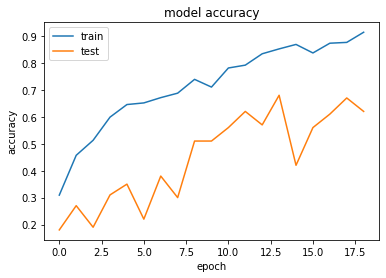

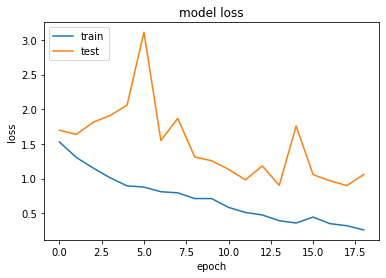

In [ ]:
# Plotting the result of Model:

# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Result:**
-  loss: 0.3938
-  categorical_accuracy: 0.8522
-  val_loss: 0.9038
-  val_categorical_accuracy: 0.6800
-  Result: LSTM-based model struggled to generalize; moderate validation accuracy (66%).
-  Next Step: Adding more Conv2D layers before LSTM and tuning dropout values.

## Model 5
-  Model - The model consists 3 Conv2D Layers with TimeDistributed wrapper, BatchNormalization, MaxPooling2D and Flatten Layer after TimeDistributed for flattening each frame's feature maps, LSTM Layer with 128 units for sequence processing and a dropout layer is also present after the dense layer.
-  Number of Images - 30
-  Image Size - 120X120
-  Number of epoch - 30
-  Batch Size - 16

In [ ]:
model = models.Sequential()

# First Conv2D layer
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=(30, 120, 120, 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Second Conv2D layer 
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Third Conv2D layer 
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.3))

# Flatten the output 
model.add(TimeDistributed(Flatten()))

# LSTM layer 
model.add(LSTM(128, return_sequences=False, dropout=0.5))

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# Output layer 
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Create a directory to store the model checkpoints
model_name = 'second_cnnlstm_models/' 
if not os.path.exists(model_name):
    os.mkdir(model_name)

# File path for saving the model checkpoints with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Model checkpoint callback with save_freq instead of period
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True,  
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch') 

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate is reduced
    patience=5,          # Number of epochs with no improvement before reducing the learning rate
    verbose=1,           # 1: Print a message when learning rate is reduced
    min_lr=1e-6          # Minimum learning rate
)

# Define Early stopping for stopping the training if accuracy does not increase
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5
)
# Add both callbacks to the list
callbacks_list = [early_stopping, checkpoint, LR]

# Calculate steps_per_epoch and validation_steps
if num_train_sequences % batch_size == 0:
    steps_per_epoch = num_train_sequences // batch_size
else:
    steps_per_epoch = num_train_sequences // batch_size + 1

if num_val_sequences % batch_size == 0:
    validation_steps = num_val_sequences // batch_size
else:
    validation_steps = num_val_sequences // batch_size + 1

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 30, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 60, 60, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 30, 30, 32)  

In [ ]:
# Start model training
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Source path = datasets/Project_data/train ; batch size = 16
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.4742 - categorical_accuracy: 0.3695Source path = datasets/Project_data/val ; batch size = 16

Epoch 00001: val_categorical_accuracy improved from -inf to 0.18000, saving model to second_cnnlstm_models/model-00001-1.47416-0.36953-1.65362-0.18000.keras
42/42 [==============================] - 53s 1s/step - loss: 1.4742 - categorical_accuracy: 0.3695 - val_loss: 1.6536 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.2559 - categorical_accuracy: 0.4721
Epoch 00002: val_categorical_accuracy improved from 0.18000 to 0.22000, saving model to second_cnnlstm_models/model-00002-1.25586-0.47210-1.70494-0.22000.keras
42/42 [==============================] - 49s 1s/step - loss: 1.2559 - categorical_accuracy: 0.4721 - val_loss: 1.7049 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/30
42/42 [===

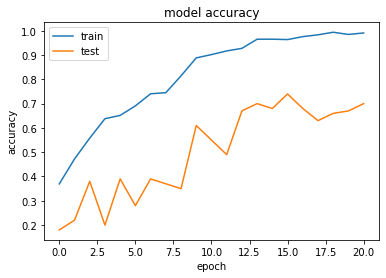

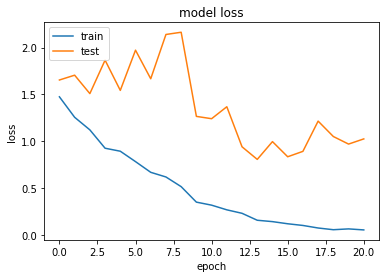

In [ ]:
# Plotting the result of Model:

# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Result:**
-  loss: 0.1203
-  categorical_accuracy: 0.9638
-  val_loss: 0.8349
-  val_categorical_accuracy: 0.7400
-  Result: Moderate overfitting; validation accuracy lower than training accuracy.
-  Next Step: Adding an additional layer.

## Model 6
-  Model - The model consists 4 Conv2D Layers with TimeDistributed wrapper, BatchNormalization, MaxPooling2D and Flatten Layer after TimeDistributed for flattening each frame's feature maps, LSTM Layer with 128 units for sequence processing and a dropout layers.
-  Number of Images - 30
-  Image Size - 120X120
-  Number of epoch - 30
-  Batch Size - 16

In [ ]:
model = models.Sequential()

# First Conv2D layer
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=(30, 120, 120, 3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Second Conv2D layer 
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Third Conv2D layer 
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Fourth Conv2D layer 
model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.3))

# Flatten the output 
model.add(TimeDistributed(Flatten()))

# LSTM layer 
model.add(LSTM(128, return_sequences=False, dropout=0.5))

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# Output layer 
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Create a directory to store the model checkpoints
model_name = 'third_cnnlstm_models/' 
if not os.path.exists(model_name):
    os.mkdir(model_name)

# File path for saving the model checkpoints with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Model checkpoint callback with save_freq instead of period
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True,  
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch') 

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate is reduced
    patience=5,          # Number of epochs with no improvement before reducing the learning rate
    verbose=1,           # 1: Print a message when learning rate is reduced
    min_lr=1e-6          # Minimum learning rate
)

# Define Early stopping for stopping the training if accuracy does not increase
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5
)
# Add both callbacks to the list
callbacks_list = [early_stopping, checkpoint, LR]

# Calculate steps_per_epoch and validation_steps
if num_train_sequences % batch_size == 0:
    steps_per_epoch = num_train_sequences // batch_size
else:
    steps_per_epoch = num_train_sequences // batch_size + 1

if num_val_sequences % batch_size == 0:
    validation_steps = num_val_sequences // batch_size
else:
    validation_steps = num_val_sequences // batch_size + 1


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 60, 60, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 30, 30, 32)  

In [ ]:
# Start model training
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Source path = datasets/Project_data/train ; batch size = 16
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.4885 - categorical_accuracy: 0.3454Source path = datasets/Project_data/val ; batch size = 16

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to third_cnnlstm_models/model-00001-1.48847-0.34540-1.76834-0.23000.keras
42/42 [==============================] - 53s 1s/step - loss: 1.4885 - categorical_accuracy: 0.3454 - val_loss: 1.7683 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.1917 - categorical_accuracy: 0.5038
Epoch 00002: val_categorical_accuracy did not improve from 0.23000
42/42 [==============================] - 49s 1s/step - loss: 1.1917 - categorical_accuracy: 0.5038 - val_loss: 1.6662 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.0859 - categorical_accuracy: 0.5520
Epoch 000

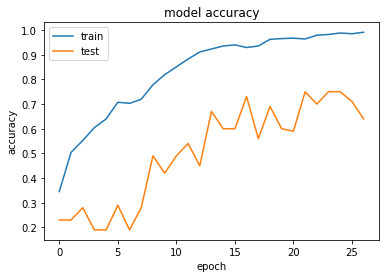

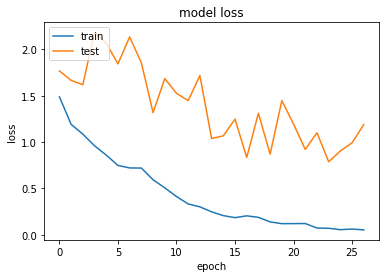

In [ ]:
# Plotting the result of Model:

# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Result:**
-  loss: 0.1203
-  categorical_accuracy: 0.9638
-  val_loss: 0.9207
-  val_categorical_accuracy: 0.7500
-  Result: Strong training performance (96%) but validation accuracy (75%) still shows potential overfitting.
-  Next Step: Trying with CNN GRU

## Model 7
-  Model - The model consists 3 Conv2D Layers with TimeDistributed wrapper, BatchNormalization, and MaxPooling2D, Flatten Layer after TimeDistributed for flattening each frame's feature maps, GRU Layer with 128 units for sequence processing and increased Dropout Layers to address overfitting.
-  Number of Images - 30
-  Image Size - 120X120
-  Number of epoch - 30
-  Batch Size - 8

In [ ]:
clear_session()

batch_size =8 
# Define the model
model = Sequential()

# First Conv2D layer
model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=(30, 120, 120, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Second Conv2D layer
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# Third Conv2D layer
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Dropout(0.3)))  

# Flatten the output
model.add(TimeDistributed(Flatten()))

# GRU layer
model.add(GRU(128, return_sequences=False, dropout=0.5))

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4)) 

# Output layer
model.add(Dense(5, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Create a directory to store the model checkpoints
model_name = 'first_cnngru_models/' 
if not os.path.exists(model_name):
    os.mkdir(model_name)

# File path for saving the model checkpoints with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Model checkpoint callback with save_freq instead of period
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True,  
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch') 

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate is reduced
    patience=5,          # Number of epochs with no improvement before reducing the learning rate
    verbose=1,           # 1: Print a message when learning rate is reduced
    min_lr=1e-6          # Minimum learning rate
)

# Define Early stopping for stopping the training if accuracy does not increase
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5
)
# Add both callbacks to the list
callbacks_list = [early_stopping, checkpoint, LR]

# Calculate steps_per_epoch and validation_steps
if num_train_sequences % batch_size == 0:
    steps_per_epoch = num_train_sequences // batch_size
else:
    steps_per_epoch = num_train_sequences // batch_size + 1

if num_val_sequences % batch_size == 0:
    validation_steps = num_val_sequences // batch_size
else:
    validation_steps = num_val_sequences // batch_size + 1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)   1

In [ ]:
# Start model training
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Source path = datasets/Project_data/train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.5179 - categorical_accuracy: 0.3771Source path = datasets/Project_data/val ; batch size = 8

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to first_cnngru_models/model-00001-1.51789-0.37707-2.23166-0.23000.keras
83/83 [==============================] - 52s 608ms/step - loss: 1.5179 - categorical_accuracy: 0.3771 - val_loss: 2.2317 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.2093 - categorical_accuracy: 0.4736
Epoch 00002: val_categorical_accuracy did not improve from 0.23000
83/83 [==============================] - 49s 598ms/step - loss: 1.2093 - categorical_accuracy: 0.4736 - val_loss: 2.3129 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.0569 - categorical_accuracy: 0.5701
Epoch 

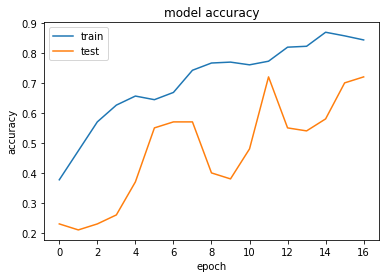

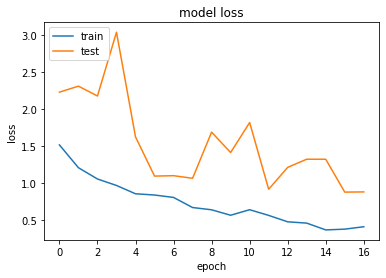

In [ ]:
# Plotting the result of Model:

# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Result:**
-  loss: 0.5642
-  categorical_accuracy: 0.7722
-  val_loss: 0.9183
-  val_categorical_accuracy: 0.7200
-  Result : Model's performance shows promising results.
-  Next Step: Trying with Transfer Learning using MobileNetV2

## Model 8
-  Model - Transfer Learning Using MobileNetV2 with Bidirectional GRU
-  Number of Images - 30
-  Image Size - 120X120
-  Number of epoch - 20
-  Batch Size - 8

In [35]:
from tensorflow.keras.layers import Bidirectional

batch_size = 8
clear_session()
# Load MobileNetV2 without the top layer
mobilenetv2_transfer = MobileNetV2(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in mobilenetv2_transfer.layers[-20:]:
    layer.trainable = True
    
# Define the model
model = Sequential()

# Add TimeDistributed MobileNetV2
model.add(TimeDistributed(mobilenetv2_transfer, input_shape=(30, 120, 120, 3)))

# Add BatchNormalization, MaxPooling, and Flatten
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

# Add GRU layer
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.3))

# Add Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Add Output Layer
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary
model.summary()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Create a directory to store the model checkpoints
model_name = 'transferlearning_models/' 
if not os.path.exists(model_name):
    os.mkdir(model_name)

# File path for saving the model checkpoints with .keras extension
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# Model checkpoint callback with save_freq instead of period
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True,  
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch') 

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate is reduced
    patience=5,          # Number of epochs with no improvement before reducing the learning rate
    verbose=1,           # 1: Print a message when learning rate is reduced
    min_lr=1e-6          # Minimum learning rate
)

# Define Early stopping for stopping the training if accuracy does not increase
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy',
    patience=5
)
# Add both callbacks to the list
callbacks_list = [early_stopping, checkpoint, LR]

# Calculate steps_per_epoch and validation_steps
if num_train_sequences % batch_size == 0:
    steps_per_epoch = num_train_sequences // batch_size
else:
    steps_per_epoch = num_train_sequences // batch_size + 1

if num_val_sequences % batch_size == 0:
    validation_steps = num_val_sequences // batch_size
else:
    validation_steps = num_val_sequences // batch_size + 1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 4, 4, 1280)   2257984   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 4, 4, 1280)   5120      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 2, 2, 1280)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 5120)         0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              4

In [36]:
# Start model training
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    initial_epoch=0)

Source path = datasets/Project_data/train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.3291 - categorical_accuracy: 0.4721Source path = datasets/Project_data/val ; batch size = 8

Epoch 00001: val_categorical_accuracy improved from -inf to 0.38000, saving model to transferlearning_models/model-00001-1.32909-0.47210-1.47241-0.38000.keras
83/83 [==============================] - 58s 619ms/step - loss: 1.3291 - categorical_accuracy: 0.4721 - val_loss: 1.4724 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.9326 - categorical_accuracy: 0.6561
Epoch 00002: val_categorical_accuracy improved from 0.38000 to 0.41000, saving model to transferlearning_models/model-00002-0.93256-0.65611-1.44020-0.41000.keras
83/83 [==============================] - 49s 590ms/step - loss: 0.9326 - categorical_accuracy: 0.6561 - val_loss: 1.4402 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/30
83

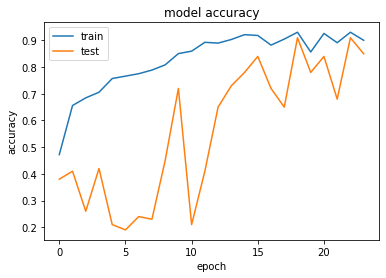

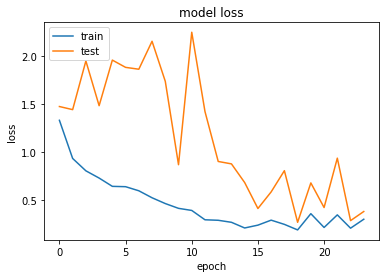

In [37]:
# Plotting the result of Model:

# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Result:**
-  loss: 0.1896
-  categorical_accuracy: 0.9306
-  val_loss: 0.2685
-  val_categorical_accuracy: 0.92000
-  This looks like the best model

## Doing prediction using the best model trained so far

In [38]:
from tensorflow.keras.models import load_model

test_generator = generator(val_path, val_doc, batch_size)
img, label = next(test_generator)
final_model = load_model("transferlearning_models/model-00019-0.18959-0.93062-0.26853-0.91000.keras")
# Doing prediction on first 8 images
prediction = final_model.predict(img[0:8])
pred_label = np.argmax(prediction,axis=1)

Source path = datasets/Project_data/val ; batch size = 8


In [39]:
final_result = []
for i in pred_label:
    li = [0, 0, 0, 0, 0]
    li[i] = 1
    final_result.append(li)
# Predicted Labels
print(final_result)

[[0, 0, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]]


# 4. Conclusion
The last model of using the pretrained MobileNetV2 in its frozen state with Bidirectional GRU  shows the best results with 91% validation accuracy